˙ 기존 resnet50이 정확도가 자꾸 80% 언저리, resnet50이 원래 다른 모델보다 정확도가 20-30% 낮다는 것을 감안, resnet100 한번 try

In [0]:
%tensorflow_version 1.x

In [2]:
# 1. 필요 모듈 import
import tensorflow as tf
from keras.applications import ResNet101
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras import optimizers
from keras.layers.normalization import BatchNormalization
import os, numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
# 2. npy 데이터를 불러와서 모델 학습
X_train, X_test, y_train, y_test = np.load("/content/drive/My Drive/fin.npy", allow_pickle=True)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}') 

X_train: (28810, 64, 64, 3), y_train: (28810, 5)
X_test: (7203, 64, 64, 3), y_test: (7203, 5)


In [4]:
# 모델 생성
model = ResNet101(input_shape=(64, 64, 3), include_top=True, weights=None, pooling='max')  
x = model.output
x = Dense(1024, name='fully', init='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(512, init='normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(256, init='normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(5, activation='softmax')(x)
model = Model(model.input, x)
model.summary()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, name="fully", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="normal")`
  if __name__ == '__main__':


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [5]:
# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.7, clipvalue=0.5), metrics=['accuracy'])

In [6]:
# 5. 모델 학습
model_dir = "./model"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
model_path = model_dir + '/test.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(X_train, y_train, epochs=100, batch_size=100, callbacks=[checkpoint, early_stopping], validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 23048 samples, validate on 5762 samples
Epoch 1/100
23048/23048 [==============================] - 111s 5ms/step - loss: 1.0983 - acc: 0.5609 - val_loss: 1.1260 - val_acc: 0.5644

Epoch 00001: val_loss improved from inf to 1.12604, saving model to ./model/test.model
Epoch 2/100
23048/23048 [==============================] - 63s 3ms/step - loss: 0.5775 - acc: 0.7884 - val_loss: 0.9793 - val_acc: 0.5951

Epoch 00002: val_loss improved from 1.12604 to 0.97928, saving model to ./model/test.model
Epoch 3/100
23048/23048 [==============================] - 63s 3ms/step - loss: 0.4245 - acc: 0.8437 - val_loss: 0.9680 - val_acc: 0.6946

Epoch 00003: val_loss improved from 0.97928 to 0.96797, saving model to ./model/test.model
Epoch 4/100
23048/23048 [==============================] - 63s 3ms/step - loss: 0.3231 - acc: 0.8830 - val_loss: 0.8230 - val_acc: 0.7447

Epoch 00004: val_loss improve

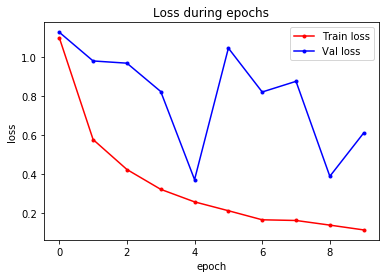

In [7]:
# loss 그래프
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss during epochs')
plt.show()

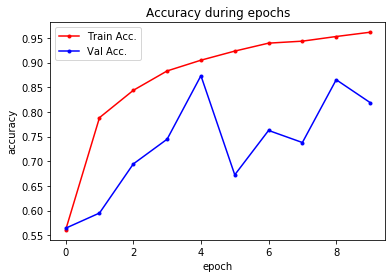

In [8]:
# acc 그래프
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(x, train_acc, marker='.', c='red', label='Train Acc.')
plt.plot(x, val_acc, marker='.', c='blue', label='Val Acc.')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy during epochs')
plt.show()

In [9]:
# Test set으로 모델 평가
score = model.evaluate(X_test, y_test, verbose=0)
print('Training loss:', score[0])
print('Training accuracy: ', score[1])

Training loss: 0.616604902944589
Training accuracy:  0.8152158822712758


In [0]:
# 모델 저장하기
from keras.models import load_model
model.save('fin_resnet101.h5')

In [11]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
test_true = np.argmax(y_test, axis=1)
print(test_true)
test_pred = np.argmax(model.predict(X_test), axis=1)
print(test_pred)

cm = confusion_matrix(test_true, test_pred)
print(cm)

[3 1 2 ... 2 1 0]
[3 1 2 ... 2 1 0]
[[ 968  153  183   81   55]
 [   0 1335   13    4   25]
 [   2  152 1097  143    1]
 [  65   76  296 1048   33]
 [   6   16   25    2 1424]]


In [12]:
# Classification Report
from sklearn.metrics import classification_report
report = classification_report(test_true, test_pred, target_names=os.listdir('/content/drive/My Drive/Final'))
print(report)

              precision    recall  f1-score   support

       nevus       0.93      0.67      0.78      1440
          df       0.77      0.97      0.86      1377
      eschar       0.68      0.79      0.73      1395
          vl       0.82      0.69      0.75      1518
         mel       0.93      0.97      0.95      1473

    accuracy                           0.82      7203
   macro avg       0.83      0.82      0.81      7203
weighted avg       0.83      0.82      0.81      7203

